In [59]:
import numpy as np
import pandas as pd
import PcmPy as pcm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sys
sys.path.insert(0, '..')
import globals as gl

In [60]:
dataset = ['stroke',  'intact']
mapping = ['on', 'off']
tinfo = pd.read_csv('../data/post_rehab/tinfo.tsv', sep='\t')
N = 40
Nc, Nd = 15, 21

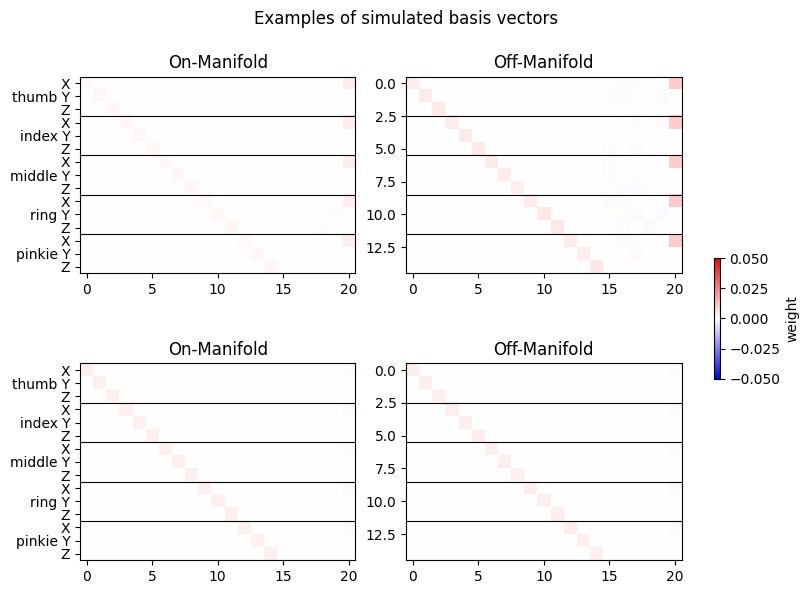

In [61]:
A_diff_on, A_diff_off = np.zeros((2, N, Nc, Nd)), np.zeros((2, N, Nc, Nd))
for d, ds in enumerate(dataset):
    for s, sn in enumerate(tinfo.subj_id.unique()):
        A0 = np.load(f'../data/basis_vectors/basis_vectors.{ds}.{sn}.npy')
        A_on = np.load(f'../data/post_rehab/basis_vectors.on-manifold.{ds}.{sn}.npy')
        A_off = np.load(f'../data/post_rehab/basis_vectors.off-manifold.{ds}.{sn}.npy')
        A_diff_on[d, s] = A_on - A0
        A_diff_off[d, s] = A_off - A0

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=[8, 6])

for d in range(len(dataset)):
    ax = axs[d]
    ax[0].imshow(A_diff_on[d].mean(axis=0), vmin=-.05, vmax=.05, cmap='bwr')
    ax[1].imshow(A_diff_off[d].mean(axis=0), vmin=-.05, vmax=.05, cmap='bwr')
    ax[0].set_title('On-Manifold')
    ax[1].set_title('Off-Manifold')
    ax[0].set_yticks(np.arange(0, Nc))
    ax[0].set_yticklabels(gl.channels)
    for a in ax:
        for i in [2.5, 5.5, 8.5, 11.5]:
            a.axhline(i, color='k', lw=.8)

cax = axs[0, 0].get_images()[0]
cbar = fig.colorbar(cax, ax=axs, orientation='vertical', fraction=.01)
cbar.set_label('weight')

fig.suptitle('Examples of simulated basis vectors')

plt.show()

In [65]:
euc = np.zeros((2, N, 5, 6, 6)) # (groups, n_subj, n_finger, dir, dir)
cos = np.zeros_like(euc)
for d, map in enumerate(mapping):
    for f, fi in enumerate(tinfo.finger.unique()):
        for s, sn in enumerate(tinfo.subj_id.unique()):
            tinfo_s = tinfo[(tinfo.subj_id == sn) & (tinfo.group == 'stroke') & (tinfo.mapping==map)]
            X = np.load(f'../data/post_rehab/single_finger.post_rehab.{map}-manifold.stroke.{sn}.npy') # (trials, time, channels)
            X_f = X[tinfo_s.finger == f, 50] #.mean(axis=1)
            X_m = X_f.reshape(6, -1, 15).mean(axis=1)
            G = X_m @ X_m.T
            diag = np.diag(G)
            norm = np.sqrt(np.outer(diag, diag))
            D2 = diag[:, None] + diag[None, :] - 2 * G
            euc[d, s, f] = np.sqrt(D2)
            cos[d, s, f] = 1 - G / norm

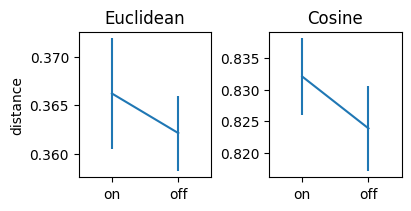

In [66]:
euc_p = euc.mean(axis=(2, 3, 4))
euc_avg = euc_p.mean(axis=1)
euc_err = euc_p.std(axis=1) / np.sqrt(N)
cos_p = cos.mean(axis=(2, 3, 4))
cos_avg = cos_p.mean(axis=1)
cos_err = cos_p.std(axis=1) / np.sqrt(N)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=[4, 2], sharex=True)

axs[0].errorbar(mapping, euc_avg, yerr=euc_err)
axs[0].set_title('Euclidean')
axs[0].set_ylabel('distance')
axs[1].errorbar(mapping, cos_avg, yerr=cos_err)
axs[1].set_xlim(-.5, 1.5)
axs[1].set_title('Cosine')

plt.show()

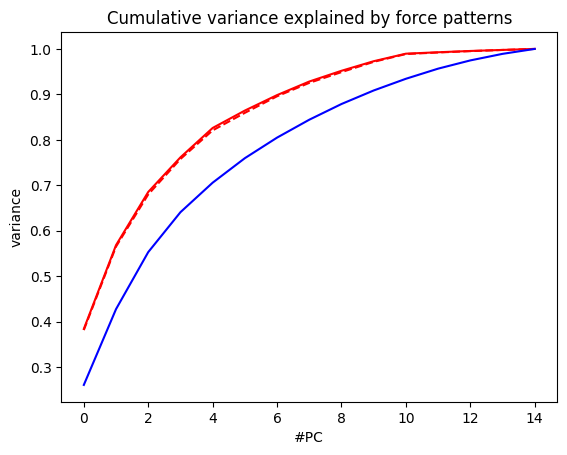

In [67]:
scaler = StandardScaler()
pca = PCA()
var_expl = np.zeros((3, N, 15)) # (groups, n_subj, n_channels)
for d, map in enumerate(mapping):
    for s, sn in enumerate(tinfo.subj_id.unique()):
        X = np.load(f'../data/post_rehab/single_finger.post_rehab.{map}-manifold.stroke.100.npy') # (trials, time, channels)
        X_r = X.reshape(-1, X.shape[-1])
        X_norm = scaler.fit_transform(X_r)
        pca.fit(X_norm)
        var_expl[d, s] = pca.explained_variance_ratio_

for s, sn in enumerate(tinfo.subj_id.unique()):
    X = np.load(f'../data/baseline/single_finger.pretraining.intact.{sn}.npy') # (trials, time, channels)
    X_r = X.reshape(-1, X.shape[-1])
    X_norm = scaler.fit_transform(X_r)
    pca.fit(X_norm)
    var_expl[-1, s] = pca.explained_variance_ratio_

fig, ax = plt.subplots()

ax.plot(np.cumsum(var_expl[0].mean(axis=0)), color='r', label='on-manifold')
ax.plot(np.cumsum(var_expl[1].mean(axis=0)), color='r', ls='--', label='off-manifold')
ax.plot(np.cumsum(var_expl[2].mean(axis=0)), color='b', ls='-', label='intact')
ax.set_title('Cumulative variance explained by force patterns')
ax.set_xlabel('#PC')
ax.set_ylabel('variance')

plt.show()